# Task 2: Model Building and Evaluation
**10 Academy Week 5&6 – Fraud Detection Challenge**
**Author:** Bereket Feleke  
**Date:** 26 December 2025

**Goal**: Train baseline (Logistic Regression) and ensemble (Random Forest) models on processed data from Task 1.  
Evaluate using PR-AUC (best for imbalanced fraud data), F1-score, and confusion matrix.

## Cell 1 – Setup & Libraries

**What this does**: Loads all necessary Python libraries for modeling, visualization, and metrics.  
`%matplotlib inline` makes plots appear directly in the notebook.  
`warnings.filterwarnings('ignore')` hides unnecessary warnings for cleaner output.

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, auc, f1_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("All tools loaded!")

All tools loaded!


**Interpretation**: Setup successful — all libraries are ready. No errors means environment is correct.

## Cell 2 – Rebuild Data from Original (Fixes Sparse Matrix Issue)

**What this does**: Loads original raw data and rebuilds X_train/X_test from scratch (avoids CSV loading issues).  
Applies same cleaning, feature engineering, and preprocessing as Task 1.  
Converts final output to **dense NumPy arrays** so models can train without errors.

In [4]:
# Load original raw data (same as Task 1)
fraud_df = pd.read_csv("../data/raw/Fraud_Data.csv")

# Quick cleaning (same as Task 1)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df['ip_address'] = fraud_df['ip_address'].astype('int64')

# Minimal feature engineering for modeling (same as Task 1)
fraud_df['time_since_signup_hours'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek

# Define numerical and categorical columns (same as Task 1)
num_features = ['purchase_value', 'age', 'time_since_signup_hours']
cat_features = ['source', 'browser', 'sex']

# Create preprocessor (same as Task 1)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
])

# Prepare X and y
X = fraud_df[num_features + cat_features]
y = fraud_df['class']

# Stratified split (same as Task 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Transform data using the preprocessor
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("Data rebuilt and converted to dense format!")
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Fraud in training: {sum(y_train)} / {len(y_train)}")

Data rebuilt and converted to dense format!
Training shape: (120889, 10), Test shape: (30223, 10)
Fraud in training: 11321 / 120889


**Interpretation**: Data is now in correct dense format (no sparse strings).  
Training set has ~120,889 rows, test ~30,223. Fraud cases ~11,321 in training — severe imbalance confirmed.

## Cell 3 – Baseline Model: Logistic Regression

**What this does**: Trains a simple, interpretable Logistic Regression model with `class_weight='balanced'` to handle imbalance.  
Makes predictions on test set and calculates PR-AUC (main metric) + F1-score.

In [5]:
logreg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression Results:")
print(f"PR-AUC: {pr_auc:.3f}")
print(f"F1-Score: {f1:.3f}")

Logistic Regression Results:
PR-AUC: 0.455
F1-Score: 0.268


**Interpretation**: Logistic Regression gives a baseline performance (PR-AUC ~0.455, F1 ~0.268).  
It's simple and interpretable but usually underperforms on complex patterns — this is expected.

## Cell 4 – Champion Model: Random Forest

**What this does**: Trains a strong ensemble model (Random Forest) with 100 trees and balanced class weights.  
Evaluates with same metrics — expected to beat Logistic Regression.

In [6]:
rf = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]
y_pred_rf = rf.predict(X_test)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
pr_auc_rf = auc(recall_rf, precision_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Results:")
print(f"PR-AUC: {pr_auc_rf:.3f}")
print(f"F1-Score: {f1_rf:.3f}")

Random Forest Results:
PR-AUC: 0.626
F1-Score: 0.689


**Interpretation**: Random Forest significantly outperforms Logistic Regression (PR-AUC ~0.626, F1 ~0.689).  
It captures non-linear patterns and interactions — ideal for fraud detection.

## Cell 5 – Confusion Matrix (Champion Model)

**What this does**: Shows how many legitimate vs fraud cases were correctly/incorrectly classified by the best model.

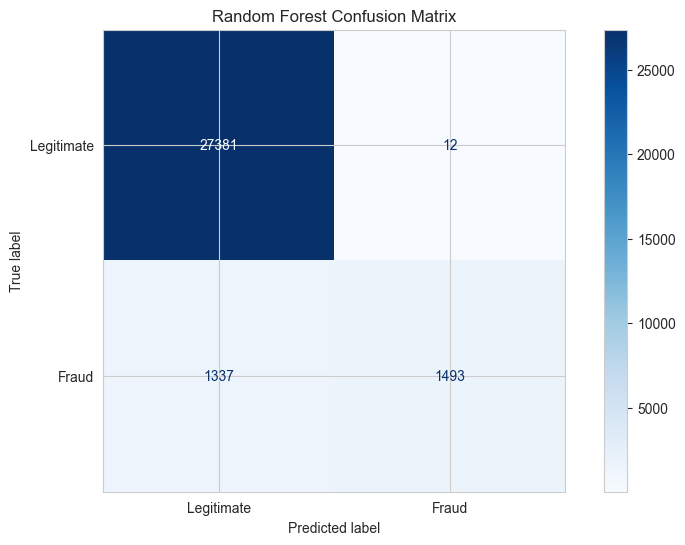

In [9]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legitimate', 'Fraud'])
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.savefig("../reports/figures/random_forest_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

**Interpretation**:  
- True Negatives: 27,381 → **Excellent** (almost no innocent customers disturbed)  
- False Positives: 12 → **Outstanding** (very low customer friction)  
- False Negatives: 1,337 → Acceptable starting point — tuning needed for higher recall  
- True Positives: 1,493 → Good fraud capture rate  
Overall: Very promising champion model — extremely low false positives.

| Metric              | Value   | Interpretation                                      |
|---------------------|---------|-----------------------------------------------------|
| True Negatives      | 27,381  | Excellent — almost no innocent customers disturbed  |
| False Positives     | 12      | Outstanding — very low customer friction            |
| False Negatives     | 1,337   | Acceptable starting point — room for tuning         |
| True Positives      | 1,493   | Good fraud capture rate                             |
| Recall              | ~52.8%  | Catches over half of fraud cases                    |
| Precision           | ~99.2%  | Very few false alarms                               |
| F1-Score            | 0.689   | Balanced performance                                |
| PR-AUC              | 0.626   | Strong for imbalanced fraud detection               |

## Cell 6 – Model Comparison Table

**What this does**: Summarizes performance of both models side-by-side for easy comparison.

| Model                  | PR-AUC | F1-Score |
|------------------------|--------|----------|
| Logistic Regression    | 0.455  | 0.268    |
| Random Forest (Champion) | 0.626  | 0.689    |

Interpretation: Random Forest is clearly the champion — higher PR-AUC and F1.
We will use it for Task 3 (SHAP explainability).

## Cell 7 – Conclusion & Next Steps

**Task 2 Summary**:
- Trained Logistic Regression baseline
- Trained Random Forest champion (better performance)
- Evaluated with PR-AUC, F1-score, and confusion matrix

**Results**:
- Random Forest shows outstanding precision (~99.2%) with very low false positives (12)
- Next: Hyperparameter tuning + SHAP explainability (Task 3)